In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pylab as pb

### Моделирование точек
Моделируем разделимое и неразделимое распределение. В первом случае есть два центра (Center1, Center2) и нормальное распределение вокруг них с соответствующими дисперсиями (gen_normal_data), во втором случае - равномерное распределение каждого класса в кубах с общими центрами и сторонами, равными утроенным Dispersion1 и Dispersion2 соответственно. Количество точек для каждого класса регулируется отдельно параметрами Number1 и Number2.
<br> Размерность пространства определяется размерностью векторов Center1 и Center2

In [2]:
def gen_normal_data():
    class1, class2 = list(), list()
    for i in range(Number1):
        buffer = [-1,]
        for j in range(len(Center1)):
            buffer.append(np.random.normal(Center1[j], Dispersion1))
        buffer.append(-1)
        class1.append(buffer)
    for i in range(Number2):
        buffer = [-1,]
        for j in range(len(Center2)):
            buffer.append(np.random.normal(Center2[j], Dispersion2))
        buffer.append(1)
        class2.append(buffer)
    return np.array(class1), np.array(class2)


def gen_uniform_data():
    Center = (Center1 + Center2)/2
    class1, class2 = list(), list()
    for i in range(Number1):
        buffer = [-1,]
        for j in range(len(Center)):
            buffer.append(Center[j] + (0.5 - np.random.sample()) * 3 * Dispersion1)
        buffer.append(-1)
        class1.append(buffer)
    for i in range(Number2):
        buffer = [-1,]
        for j in range(len(Center)):
            buffer.append(Center[j] + (0.5 - np.random.sample()) * 3 * Dispersion2)
        buffer.append(1)
        class2.append(buffer)
    return np.array(class1), np.array(class2)

#### вспомогательные функции
print_data рисует сгенерированные точки на плоскости<br>
draw_plane строит разделяющую плоскость по вектору весов

In [3]:
def print_data(class1, class2, fig):
    x1 = class1[:, 1]
    y1 = class1[:, 2]
    x2 = class2[:, 1]
    y2 = class2[:, 2]
    if class1.shape[1] > 4:
        z1 = class1[:, 3]
        z2 = class2[:, 3]
        axes = Axes3D(fig)
        axes = fig.gca(projection='3d')
        axes.plot(x1, y1, z1, lw = 0, marker = '.', ms = 10, markevery = None, color = 'red')
        axes.plot(x2, y2, z2, lw = 0, marker = '.', ms = 10, markevery = None, color = 'green')
        return axes
    else:
        plt.plot(x1, y1, 'bo')
        plt.plot(x2, y2, 'ro')
        return 0


def draw_plane(weights, color, axes):
    def line(a, b, x):
        return a*x+b

    def plane(d, a, b, c, x, y):
        return -a*x/c-b*y/c+d/c

    if weights.shape[0] == 4:
        interval_x = np.arange (-10, 10, 1)
        interval_y = np.arange (-10, 10, 1)
        xgrid, ygrid = np.meshgrid(interval_x, interval_y)
        zgrid = plane(weights[0], weights[1], weights[2], weights[3], xgrid, ygrid)
        axes.plot_surface(xgrid, ygrid, zgrid, vmin = -10, vmax = 10, color = color, alpha=0.3)
        axes.set_zlim(-10, 10)
    if weights.shape[0] == 3:
        interval = np.arange(-10, 10, 1)
        pb.plot(interval, line(-weights[1]/weights[2], weights[0]/weights[2], interval))
        pb.xlim([-10, 10])
        pb.ylim([-10, 10])


### Градиентный спуск
Q(w) возвращает значение функции невязок для вектора весов w<br>
gradQ считает градиет Q по аналитически полученной формуле: $\Large {\frac{\partial Q(\vec w)}{\partial w_i} = \sum_{k=1}^n\frac{-y_kx_k^i\exp^{-y_k<x_k, w>}}{1 + \exp^{-y_k<x_k, w>}}}$<br>
choose step выбирает размер шага, уменшая его до тех пор, кривизна первого порядка не превысит кривизну второго порядка <br>
Далее запускаем цикл, на каждом шаге считаем градиент, выбираем шаг, шагаем, если норма шага была меньше заданной точности - выходим из цикла и возвращаем результат

In [4]:
def gradient_descent():
    def Q(w):
        sum = 0
        points = np.hsplit(data, (0, data.shape[1] - 1))[1]
        class_values = np.hsplit(data, (0, data.shape[1] - 1))[2]
        for i in range(data.shape[0]):
            buf = -1 * class_values[i][0] * np.dot(w, points[i])
            sum += np.log(1 + np.exp(buf))
        return sum

    def gradQ():
        grad = np.zeros(len(w))
        points = np.hsplit(data, (0, data.shape[1] - 1))[1]
        class_values = np.hsplit(data, (0, data.shape[1] - 1))[2]
        for i in range(len(w)):
            M = 0
            for j in range(data.shape[0]):
                buf = -1 * class_values[j][0] * np.dot(w, points[j])
                M += np.exp(buf) / (1 + np.exp(buf)) * -1 * class_values[j][0] * points[j][i]
            grad[i] = M
        return grad

    def choose_step(step):
        eps = 0.1
        step1 = step
        k = 0
        while True:
            k += 1
            if Q(w - grad * step1) > Q((w) - eps*step*np.sqrt(np.dot(grad,grad))) and k<10:
                step1 /= 2
            else:
                break
        return step1

    w = np.zeros(len(Center1) + 1)
    step = 0.01
    grad = gradQ()
    itterations = 0
    while True:
        itterations += 1
        grad = gradQ()
        step = choose_step(step)
        w = w - grad * step
        if np.linalg.norm(grad*step) < accuracy:
            break
    return w, itterations

In [5]:
### Посмотрим на результаты работы алгоритма на разных данных

In [6]:
accuracy = 0.01

#### Четко разделяющиеся классы

[ -2.05181062e-06   2.03635249e+00  -1.73092866e+00] 2


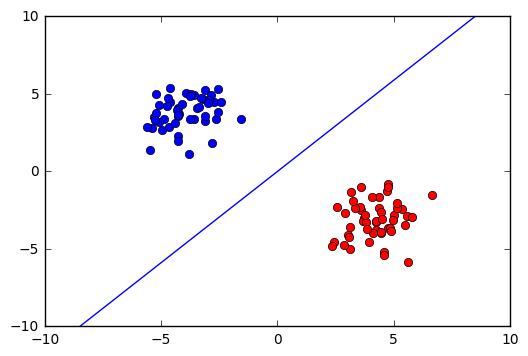

In [7]:
Center1 = np.array([-4, 4])
Center2 = np.array([4, -3])
Dispersion1 = 1
Dispersion2 = 1
Number1 = 50
Number2 = 50

fig = pb.figure()
class1, class2 = gen_normal_data()
axes = print_data(class1, class2, fig)
data = np.vstack((class1, class2))

weights, itterations = gradient_descent()
print weights, itterations

draw_plane(weights, 'black', axes)
pb.show()

#### Классы, разделяющиеся несколько хуже

[-1.33600464  0.55140355 -0.42574308] 55


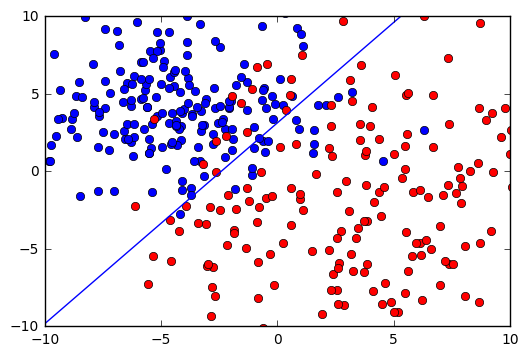

In [8]:
Center1 = np.array([-4, 4])
Center2 = np.array([4, -3])
Dispersion1 = 3
Dispersion2 = 5
Number1 = 200
Number2 = 200

fig = pb.figure()
class1, class2 = gen_normal_data()
axes = print_data(class1, class2, fig)
data = np.vstack((class1, class2))

weights, itterations = gradient_descent()
print weights, itterations

draw_plane(weights, 'black', axes)
pb.show()

#### Неотделимые классы 

[-0.0001772  -0.00915443 -0.02355752] 3


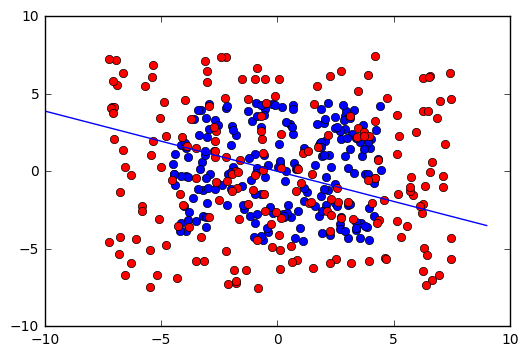

In [10]:
Center1 = np.array([-4, 4])
Center2 = np.array([4, -3])
Dispersion1 = 3
Dispersion2 = 5
Number1 = 200
Number2 = 200

fig = pb.figure()
class1, class2 = gen_uniform_data()
axes = print_data(class1, class2, fig)
data = np.vstack((class1, class2))

weights, itterations = gradient_descent()
print weights, itterations

draw_plane(weights, 'black', axes)
pb.show()

#### То же для трехмерного случая

#### Разделимые: <br>
Center1 = np.array([-4, 4, 4]) <br>
Center2 = np.array([4, -3, -4])<br>
Dispersion1 = 1<br>
Dispersion2 = 1<br>
Number1 = 200<br>
Number2 = 200
![easy1](3Deasy1.png)
![easy2](3Deasy2.png)

#### Трудноразделимые: <br>
Center1 = np.array([-4, 4, 4]) <br>
Center2 = np.array([4, -3, -4])<br>
Dispersion1 = 9<br>
Dispersion2 = 7<br>
Number1 = 200<br>
Number2 = 200
![hard1](3Dhard1.png)
![hard2](3Dhard2.png)

#### Неазделимые: <br>
Center1 = np.array([-4, 4, 4]) <br>
Center2 = np.array([4, -3, -4])<br>
Dispersion1 = 6<br>
Dispersion2 = 7<br>
Number1 = 300<br>
Number2 = 300
![impossible1](3Dimpossible1.png)
![impossible2](3Dimpossible2.png)

### Строим график зависимости числа шагов от точности
Параметры задачи: <br>
распределение нормальное <br>
Center1 = np.array([-4, 4, 4]) <br>
Center2 = np.array([4, -3, -4])<br>
Dispersion1 = 6<br>
Dispersion2 = 7<br>
Number1 = 300<br>
Number2 = 300
![step_choise1](step_choise1.png)
![step_choise2](step_choise2.png)